In [1]:
import vtk

In [2]:
%matplotlib inline
from dipy.reconst.dti import fractional_anisotropy, color_fa
from argparse import ArgumentParser
from scipy import ndimage
import os
import re
import numpy as np
import nibabel as nb
import sys
import matplotlib

# matplotlib.use('Agg')  # very important above pyplot import
import matplotlib.pyplot as plt

In [3]:
from dipy.reconst.dti import from_lower_triangular

In [4]:
img = nb.load('fibers/dogsigma_0gausigma_0tensorfsl.nii')

In [5]:
data = img.get_data()
output = from_lower_triangular(data)
output_ds = output[:, :, :, :, :]
print output.shape
print output_ds.shape

(60L, 92L, 60L, 3L, 3L)
(60L, 92L, 60L, 3L, 3L)


In [6]:
FA = fractional_anisotropy(output_ds)
FA = np.clip(FA, 0, 1)
FA[np.isnan(FA)] = 0
print FA.shape

(60L, 92L, 60L, 3L)


In [7]:
from dipy.reconst.dti import decompose_tensor

In [8]:
evalues, evectors = decompose_tensor(output_ds)
print evectors[..., 0, 0].shape
print evectors.shape[-2:]

(60L, 92L, 60L)
(3L, 3L)


In [9]:
print FA[:, :, :, 0].shape

(60L, 92L, 60L)


In [10]:
RGB = color_fa(FA[:, :, :, 0], evectors)
nb.save(nb.Nifti1Image(np.array(255 * RGB, 'uint8'), img.get_affine()), 'tensor_rgb_upper.nii.gz')

C:\Users\lk_zh\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  from ipykernel import kernelapp as app


In [11]:
def plot_rgb(im):
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})

    if im.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = im.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']

    idx = 0
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = plt.subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(im[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(im[:, pos, :], 90)
            else:
                image = im[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])

            plt.imshow(image)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 10.5, forward=True)
    return fig

In [12]:
affine = img.get_affine()

fa = nb.Nifti1Image(np.array(255 * RGB, 'uint8'), affine)
im = fa.get_data()

C:\Users\lk_zh\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  if __name__ == '__main__':


In [13]:
# print np.asarray(fa)

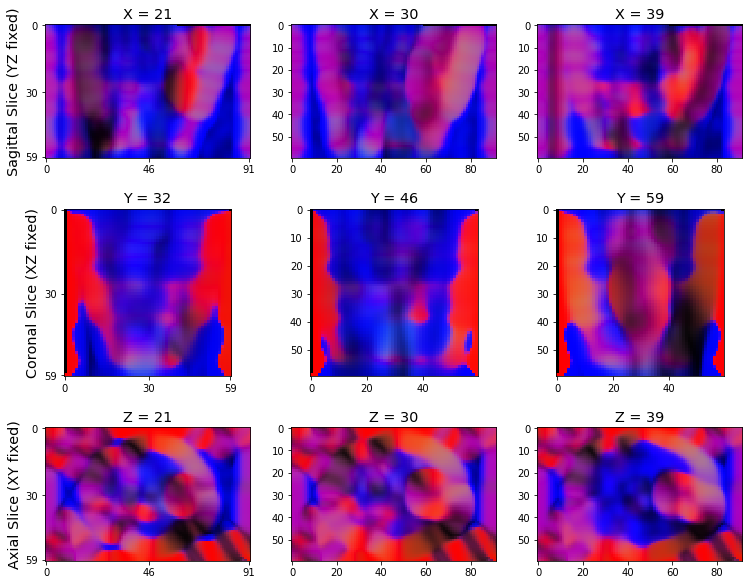

In [14]:
fig = plot_rgb(im)

In [15]:
import os

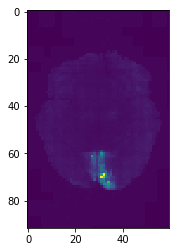

In [16]:
from PIL import Image
im = plt.imread('fibers/v100/ch0/luke40.tiff') 
plt.imshow(im)

In [17]:
import dipy.reconst.dti as dti
from dipy.reconst.dti import fractional_anisotropy
from dipy.tracking.local import (ThresholdTissueClassifier, LocalTracking)

classifier = ThresholdTissueClassifier(FA[0], .2)

In [18]:
from dipy.data import default_sphere
from dipy.direction import DeterministicMaximumDirectionGetter
from dipy.io.trackvis import save_trk
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel

from dipy.data import get_sphere

sphere = get_sphere('symmetric724')
from dipy.reconst.dti import quantize_evecs

peak_indices = quantize_evecs(evectors, sphere.vertices)

In [19]:
from dipy.tracking.eudx import EuDX

eu = EuDX(FA.astype('f8')[0], peak_indices, seeds=50000, odf_vertices = sphere.vertices, a_low=0.2)

tensor_streamlines = [streamline for streamline in eu]

In [20]:
tensor_streamlines_trk = ((sl, None, None) for sl in tensor_streamlines)

In [21]:
from argparse import ArgumentParser
from dipy.viz import window, actor
import numpy as np


def visualize(fibers, outf=None):
    """
    Takes fiber streamlines and visualizes them using DiPy
    Required Arguments:
        - fibers:
            fiber streamlines in a list as returned by DiPy
    Optional Arguments:
        - save:
            flag indicating whether or not you want the image saved
            to disk after being displayed
    """
    # Initialize renderer
    renderer = window.Renderer()

    # Add streamlines as a DiPy viz object
    stream_actor = actor.line(fibers)

    # Set camera orientation properties
    # TODO: allow this as an argument
    renderer.set_camera()  # args are: position=(), focal_point=(), view_up=()

    # Add streamlines to viz session
    renderer.add(stream_actor)

    # Display fibers
    # TODO: allow size of window as an argument
    window.show(renderer, size=(600, 600), reset_camera=False)

    # Saves file, if you're into that sort of thing...
    if outf is not None:
        window.record(renderer, out_path=outf, size=(600, 600))

In [22]:
visualize(tensor_streamlines)

In [23]:
from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

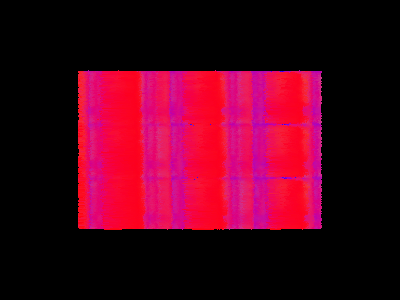

In [24]:
renderer = window.Renderer()

    # Add streamlines as a DiPy viz object
stream_actor = actor.line(tensor_streamlines)
    # Set camera orientation properties
    # TODO: allow this as an argument
renderer.set_camera()  # args are: position=(), focal_point=(), view_up=()

    # Add streamlines to viz session
renderer.add(stream_actor)

vtk_show(renderer)

In [25]:
len(tensor_streamlines)

49936

In [26]:
tensor_streamlines[0][:,0:2]

array([[ 35.21146011,  51.1700592 ],
       [ 35.63733292,  51.23426819],
       [ 36.07929993,  51.25597   ],
       [ 36.52992249,  51.23773193],
       [ 36.97113037,  51.19826889],
       [ 37.40176392,  51.13814545],
       [ 37.82439804,  51.10486984],
       [ 38.23727417,  51.10147095]])

1000


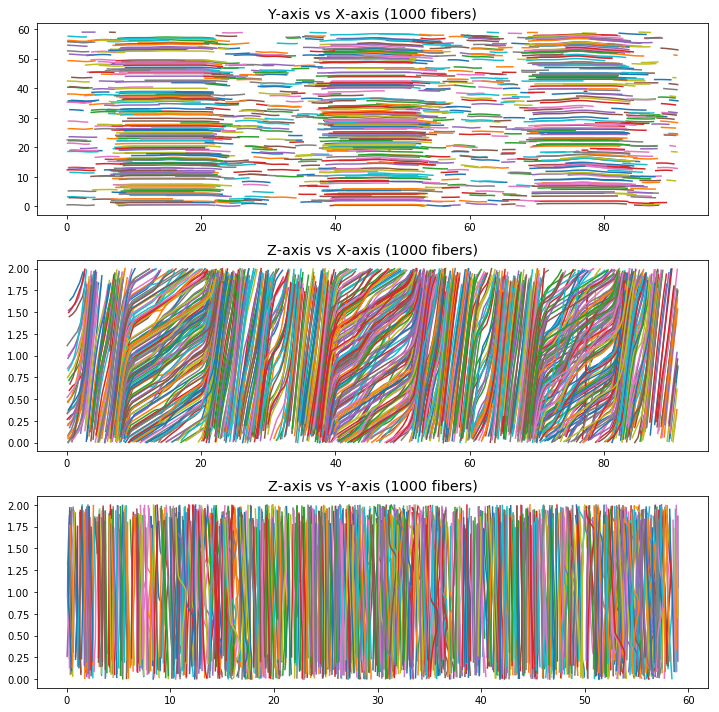

In [27]:
test = tensor_streamlines[0:1000]
print len(test)
plt.figure(1)
plt.subplots(figsize=(10, 10))
plt.subplot(311)
plt.title("Y-axis vs X-axis (1000 fibers)")
for i in range(len(test)):
    plt.plot(test[i][:,0], test[i][:,1])
plt.subplot(312)
plt.title("Z-axis vs X-axis (1000 fibers)")
for i in range(len(test)):
    plt.plot(test[i][:,0], test[i][:,2])
plt.subplot(313)
plt.title("Z-axis vs Y-axis (1000 fibers)")
for i in range(len(test)):
    plt.plot(test[i][:,1], test[i][:,2])
plt.tight_layout()
plt.show()

In [28]:
print len(tensor_streamlines)

49936


In [29]:
# from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
# from plotly.graph_objs import *
# from plotly import tools
# import plotly
# import seaborn as sns

In [30]:
# plotly.offline.init_notebook_mode()